<a href="https://colab.research.google.com/github/Ucchwas/Arrhythmia-on-ECG-Classification-using-CNN/blob/main/Arrhythmia_on_ECG_Classification_using_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [59]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical
from sklearn.utils import class_weight
import warnings
warnings.filterwarnings('ignore')

In [60]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [61]:
train_df=pd.read_csv('/content/drive/MyDrive/Datasets/mitbih_train.csv',header=None)
test_df=pd.read_csv('/content/drive/MyDrive/Datasets/mitbih_test.csv',header=None)

In [62]:
train_df[187]=train_df[187].astype(int)
equilibre=train_df[187].value_counts()
print(equilibre)

0    72471
4     6431
2     5788
1     2223
3      641
Name: 187, dtype: int64


In [63]:
test_df[187]


0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
21887    4.0
21888    4.0
21889    4.0
21890    4.0
21891    4.0
Name: 187, Length: 21892, dtype: float64

In [64]:
df = pd.read_csv('/content/drive/MyDrive/Datasets/Label.csv', error_bad_lines=False, warn_bad_lines=True, header=None)

In [65]:
df[1]

0        0
1        0
2        0
3        0
4        0
        ..
21395    0
21396    0
21397    0
21398    0
21399    0
Name: 1, Length: 21400, dtype: int64

In [66]:
test_df[187]=test_df[187].astype(int)
equilibre=test_df[187].value_counts()
print(equilibre)

0    18118
4     1608
2     1448
1      556
3      162
Name: 187, dtype: int64


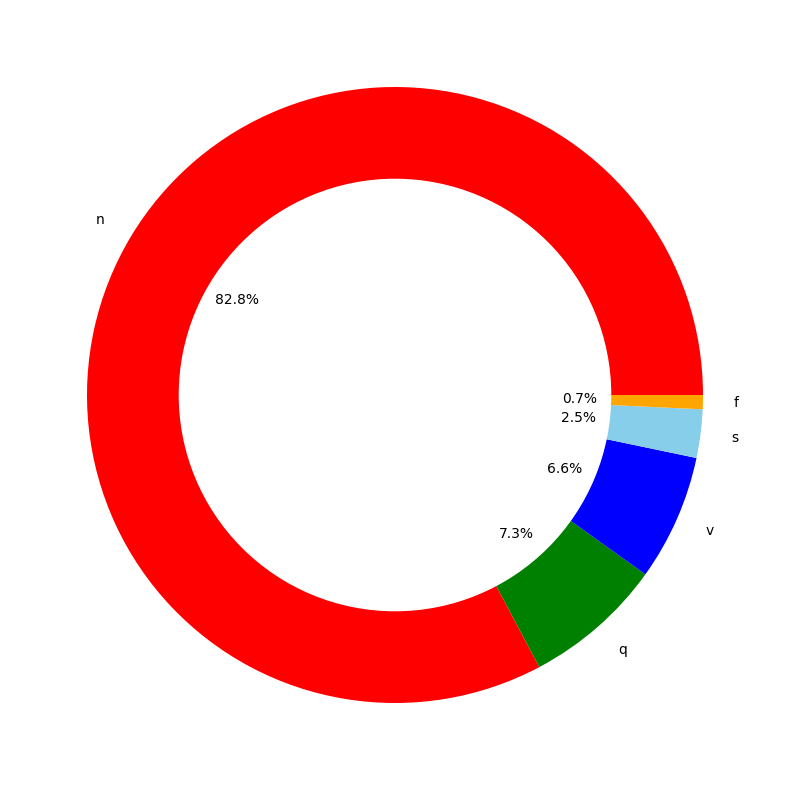

In [67]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [68]:
from sklearn.utils import resample
df_1=train_df[train_df[187]==1]
df_2=train_df[train_df[187]==2]
df_3=train_df[train_df[187]==3]
df_4=train_df[train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=20000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=20000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=20000,random_state=126)

train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

In [69]:
equilibre=train_df[187].value_counts()
print(equilibre)

0    20000
1    20000
2    20000
3    20000
4    20000
Name: 187, dtype: int64


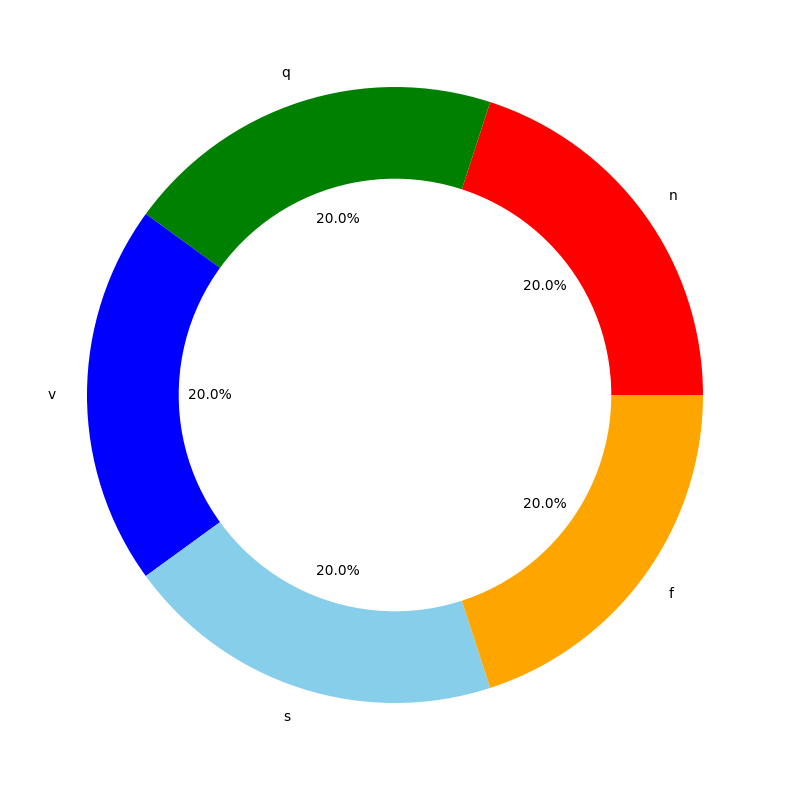

In [70]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['n','q','v','s','f'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [71]:
c=train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1))
c

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
3994,0.990654,0.712150,0.000000,0.084112,0.069159,0.119626,0.147664,0.151402,0.145794,0.153271,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0
72859,0.799197,0.690763,0.164659,0.000000,0.080321,0.132530,0.124498,0.164659,0.196787,0.180723,...,0.305221,0.305221,0.301205,0.313253,0.305221,0.309237,0.325301,0.313253,0.309237,1
76417,0.000000,0.105572,0.222874,0.357771,0.422287,0.410557,0.442815,0.448680,0.466276,0.448680,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2
80571,1.000000,0.803970,0.527295,0.305211,0.163772,0.145161,0.145161,0.120347,0.112903,0.114144,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3
81397,0.537079,0.337079,0.307865,0.298876,0.283146,0.276405,0.253933,0.222472,0.182022,0.112360,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4


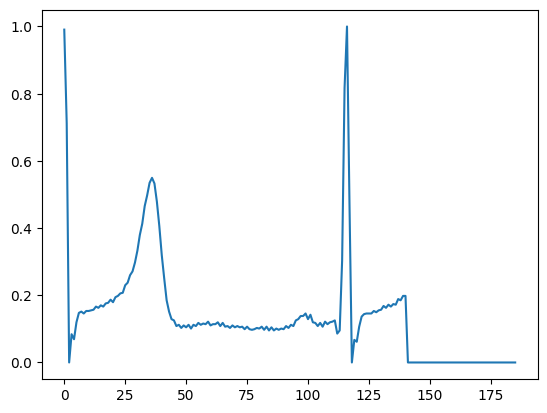

In [72]:
plt.plot(c.iloc[0,:186])

In [73]:
def plot_hist(class_number,size,min_,bins):
    img=train_df.loc[train_df[187]==class_number].values
    img=img[:,min_:size]
    img_flatten=img.flatten()

    final1=np.arange(min_,size)
    for i in range (img.shape[0]-1):
        tempo1=np.arange(min_,size)
        final1=np.concatenate((final1, tempo1), axis=None)
    print(len(final1))
    print(len(img_flatten))
    plt.hist2d(final1,img_flatten, bins=(bins,bins),cmap=plt.cm.jet)
    plt.show()

1300000
1300000


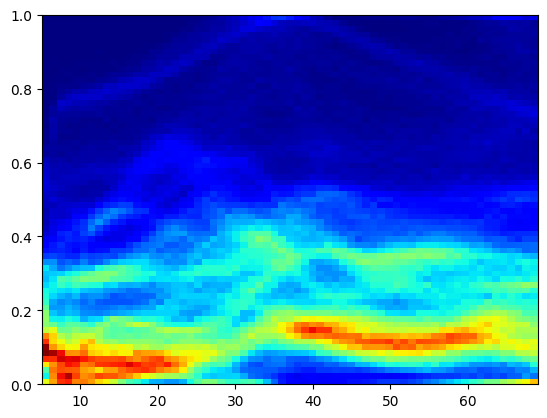

In [74]:
plot_hist(0,70,5,65)

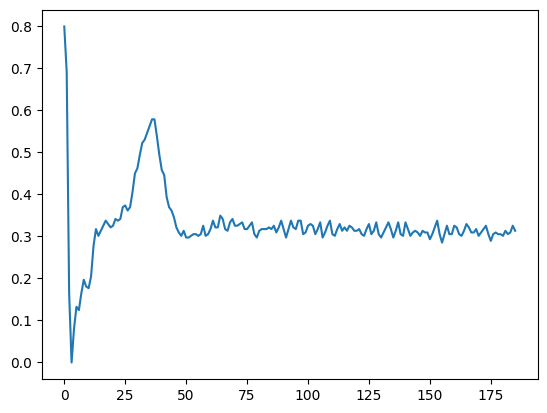

In [75]:
plt.plot(c.iloc[1,:186])

900000
900000


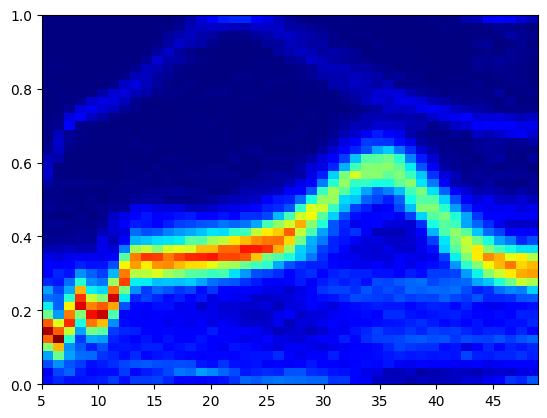

In [76]:
plot_hist(1,50,5,45) 

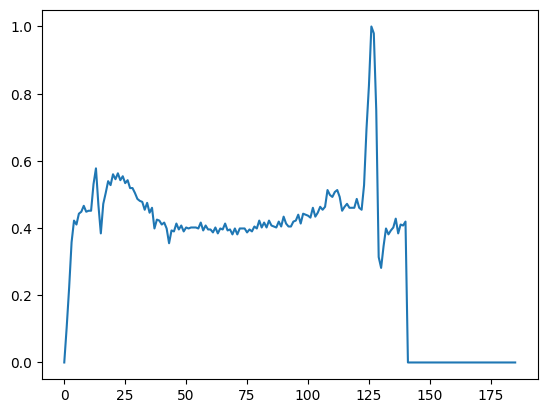

In [77]:
plt.plot(c.iloc[2,:186])

900000
900000


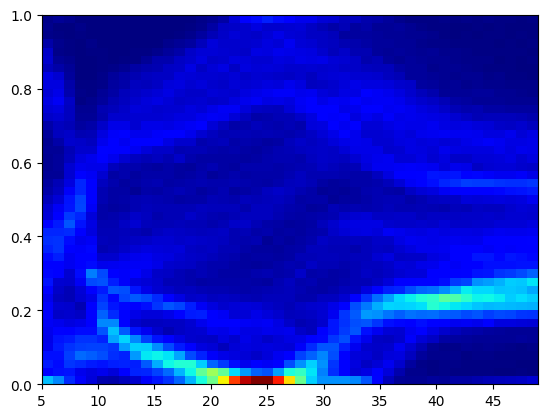

In [78]:
plot_hist(2,50,5,45)

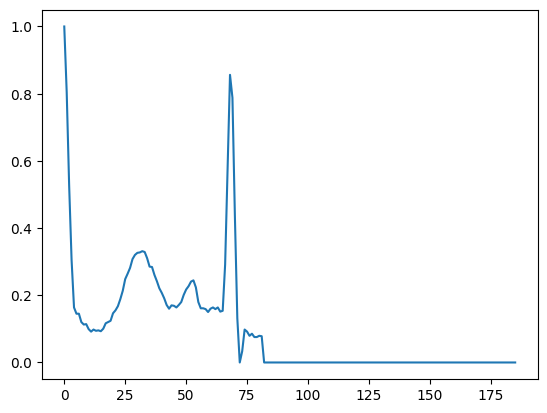

In [79]:
plt.plot(c.iloc[3,:186])

900000
900000


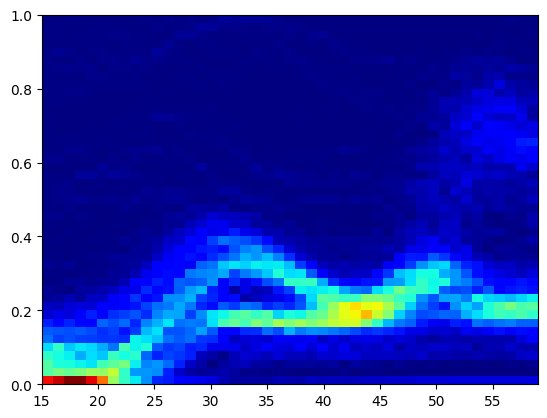

In [80]:
plot_hist(3,60,15,45)

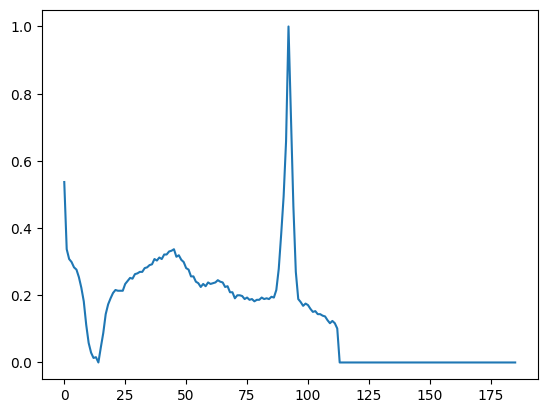

In [81]:
plt.plot(c.iloc[4,:186])

700000
700000


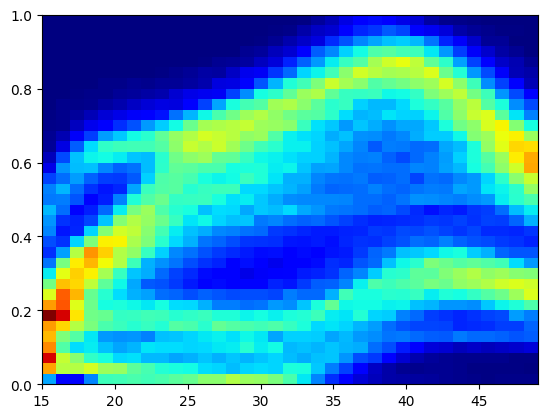

In [82]:
plot_hist(4,50,15,35)

In [83]:
def add_gaussian_noise(signal):
    noise=np.random.normal(0,0.5,186)
    return (signal+noise)

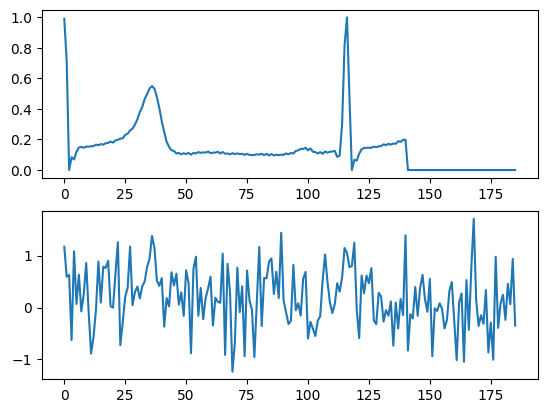

In [84]:
tempo=c.iloc[0,:186]
bruiter=add_gaussian_noise(tempo)

plt.subplot(2,1,1)
plt.plot(c.iloc[0,:186])

plt.subplot(2,1,2)
plt.plot(bruiter)

plt.show()

In [85]:
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)

In [86]:
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values
for i in range(len(X_train)):
    X_train[i,:186]= add_gaussian_noise(X_train[i,:186])
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

In [87]:
def network(X_train,y_train,X_test,y_test):
    

    im_shape=(X_train.shape[1],1)
    inputs_cnn=Input(shape=(im_shape), name='inputs_cnn')
    conv1_1=Convolution1D(64, (6), activation='relu', input_shape=im_shape)(inputs_cnn)
    conv1_1=BatchNormalization()(conv1_1)
    pool1=MaxPool1D(pool_size=(3), strides=(2), padding="same")(conv1_1)
    conv2_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool1)
    conv2_1=BatchNormalization()(conv2_1)
    pool2=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv2_1)
    conv3_1=Convolution1D(64, (3), activation='relu', input_shape=im_shape)(pool2)
    conv3_1=BatchNormalization()(conv3_1)
    pool3=MaxPool1D(pool_size=(2), strides=(2), padding="same")(conv3_1)
    flatten=Flatten()(pool3)
    dense_end1 = Dense(64, activation='relu')(flatten)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    
    
    model = Model(inputs= inputs_cnn, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy',metrics = ['accuracy'])
    
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
             ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    history=model.fit(X_train, y_train,epochs=50,callbacks=callbacks, batch_size=128,validation_data=(X_test,y_test))
    model.load_weights('best_model.h5')
    return(model,history)

In [88]:
def evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))
    
    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()
    
    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']
    
    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

In [89]:
from keras.layers import Dense, Convolution1D, MaxPool1D, Flatten, Dropout
from keras.layers import Input
from keras.models import Model
from tensorflow.keras.layers import BatchNormalization
import keras
from keras.callbacks import EarlyStopping, ModelCheckpoint

model,history=network(X_train,y_train,X_test,y_test)

Epoch 1/50
782/782 [==============================] - 119s 149ms/step - loss: 0.9092 - accuracy: 0.6499 - val_loss: 1.0366 - val_accuracy: 0.5990
Epoch 2/50
782/782 [==============================] - 111s 143ms/step - loss: 0.7860 - accuracy: 0.7019 - val_loss: 0.8482 - val_accuracy: 0.6924
Epoch 3/50
782/782 [==============================] - 110s 141ms/step - loss: 0.7490 - accuracy: 0.7157 - val_loss: 0.8805 - val_accuracy: 0.6565
Epoch 4/50
782/782 [==============================] - 110s 141ms/step - loss: 0.7226 - accuracy: 0.7247 - val_loss: 0.8682 - val_accuracy: 0.6868
Epoch 5/50
782/782 [==============================] - 116s 148ms/step - loss: 0.6964 - accuracy: 0.7368 - val_loss: 1.6821 - val_accuracy: 0.1421
Epoch 6/50
782/782 [==============================] - 107s 137ms/step - loss: 0.6728 - accuracy: 0.7442 - val_loss: 0.7765 - val_accuracy: 0.7614
Epoch 7/50
782/782 [==============================] - 112s 144ms/step - loss: 0.6464 - accuracy: 0.7559 - val_loss: 0.7666 -

Accuracy: 73.84%


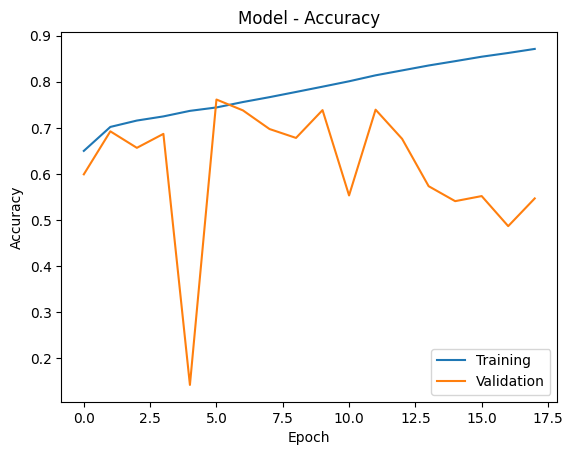

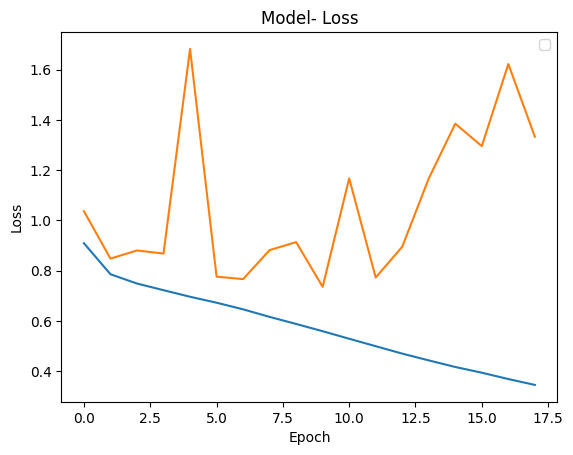

685/685 [==============================] - 6s 9ms/step


In [95]:
evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)

Normalized confusion matrix


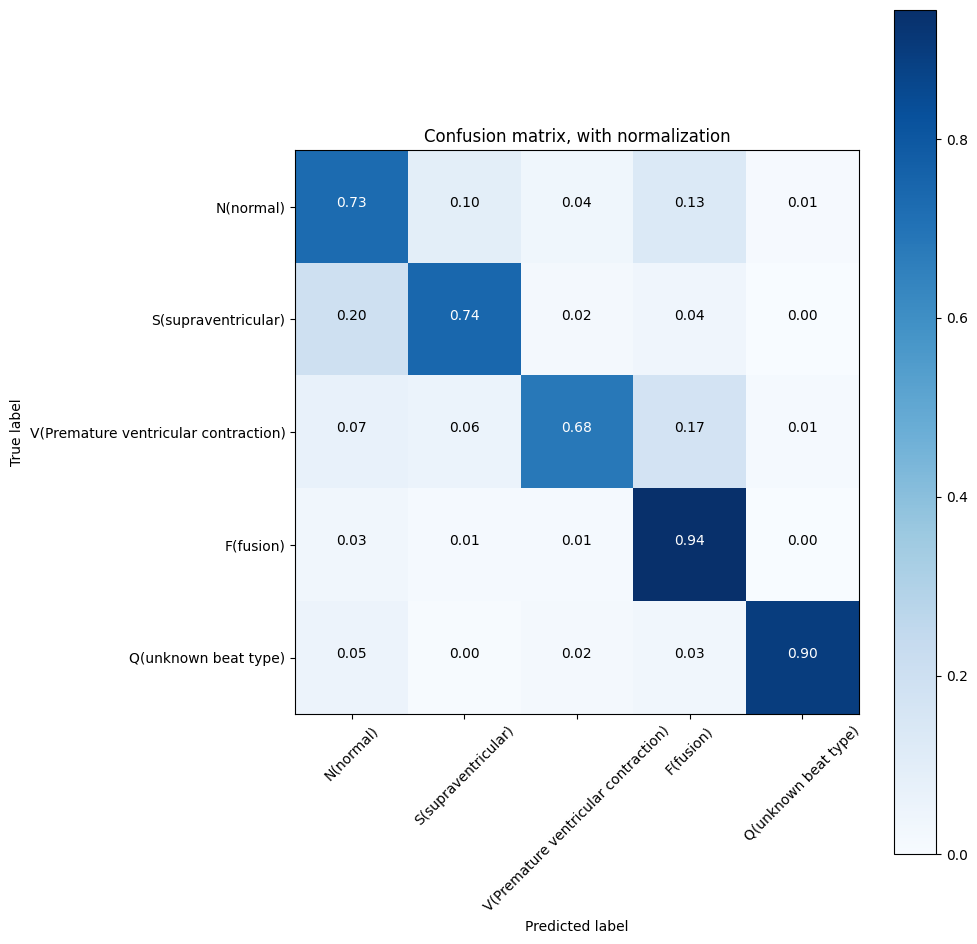

In [96]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=['N(normal)', 'S(supraventricular)', 'V(Premature ventricular contraction)', 'F(fusion)', 'Q(unknown beat type)'],normalize=True,
                      title='Confusion matrix, with normalization')
plt.show()

In [97]:
import tensorflow as tf

# Load the model
best_model = tf.keras.models.load_model("best_model.h5")

In [98]:
# convert to tensorflow lite model
converter = tf.lite.TFLiteConverter.from_keras_model(best_model)
tflite_model = converter.convert()
open("Arrhythmia on_ECG_Classification.tflite", "wb").write(tflite_model)

482748